In [1]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
# Standard imports for image classification
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical

In [2]:
data_dir = r'C:\Users\krith\leapGestRecog'

In [3]:
# 2. First inspect your folder structure
print("Inspecting dataset structure...")
sample_subject = os.path.join(data_dir, '00')
if not os.path.exists(sample_subject):
    raise FileNotFoundError(f"Subject folder not found: {sample_subject}")

actual_gestures = os.listdir(sample_subject)
print("Actual gesture folders in subject 00:", actual_gestures)

Inspecting dataset structure...
Actual gesture folders in subject 00: ['01_palm', '02_l', '03_fist', '04_fist_moved', '05_thumb', '06_index', '07_ok', '08_palm_moved', '09_c', '10_down']


In [4]:
# 3. Define gesture_classes based on ACTUAL folder names
gesture_classes = {
    '01_palm': 0,
    '02_1': 1,      # Note it's '02_1' not '02_l'
    '03_fist': 2,
    '04_fist_moved': 3,
    '05_thumb': 4,   # Confirm if it's 'thumb' or 'rhumb'
    '06_index': 5,
    '07_ok': 6,
    '08_palm_moved': 7,  # Complete name (not just '08_palm')
    '09_c': 8,
    '10_down': 9
}

In [5]:
# 4. Create the loading function
def load_dataset(data_dir):
    images = []
    labels = []
    
    print("\nStarting dataset loading...")
    
    for subject_dir in sorted(os.listdir(data_dir)):
        subject_path = os.path.join(data_dir, subject_dir)
        if not os.path.isdir(subject_path) or not subject_dir.isdigit():
            continue
            
        print(f"\nProcessing subject {subject_dir}...")
        
        for gesture_dir in sorted(os.listdir(subject_path)):
            gesture_path = os.path.join(subject_path, gesture_dir)
            
            if not os.path.isdir(gesture_path):
                continue
                
            # Check against gesture_classes
            if gesture_dir not in gesture_classes:
                print(f"  Skipping unmapped gesture: {gesture_dir}")
                continue
                
            label = gesture_classes[gesture_dir]
            image_count = 0
            
            for image_file in sorted(os.listdir(gesture_path)):
                if not image_file.lower().endswith('.png'):
                    continue
                    
                image_path = os.path.join(gesture_path, image_file)
                try:
                    img = load_img(image_path, color_mode='grayscale', target_size=(120, 160))
                    img_array = img_to_array(img)
                    images.append(img_array)
                    labels.append(label)
                    image_count += 1
                except Exception as e:
                    print(f"    Error loading {image_file}: {str(e)[:50]}...")
            
            print(f"  Loaded {image_count} images for {gesture_dir}")
    
    # Validation AFTER loading
    if len(images) == 0:
        available_gestures = set()
        for subject in os.listdir(data_dir):
            subject_path = os.path.join(data_dir, subject)
            if os.path.isdir(subject_path):
                available_gestures.update(os.listdir(subject_path))
        
        raise ValueError(
            "No images loaded!\n"
            "Possible reasons:\n"
            f"- Expected gestures: {list(gesture_classes.keys())}\n"
            f"- Available gestures: {sorted(available_gestures)}\n"
            "- Check if PNG files exist in gesture folders"
        )
    
    print(f"\nSuccessfully loaded {len(images)} images")
    return np.array(images), np.array(labels)

In [6]:
# 5. Load the dataset with proper error handling
try:
    X, y = load_dataset(data_dir)
    print("\nDataset summary:")
    print(f"- Total images: {len(X)}")
    print(f"- Image shape: {X[0].shape}")
    print(f"- Labels shape: {y.shape}")
    print(f"- Unique labels: {len(np.unique(y))}")
except Exception as e:
    print(f"\nFatal error: {e}")
    print("Please check:")
    print("1. Folder names exactly match gesture_classes keys")
    print("2. PNG files exist in gesture folders")
    print("3. File permissions allow reading")


Starting dataset loading...

Processing subject 00...
  Loaded 197 images for 01_palm
  Skipping unmapped gesture: 02_l
  Loaded 200 images for 03_fist
  Loaded 200 images for 04_fist_moved
  Loaded 200 images for 05_thumb
  Loaded 200 images for 06_index
  Loaded 200 images for 07_ok
  Loaded 200 images for 08_palm_moved
  Loaded 200 images for 09_c
  Loaded 200 images for 10_down

Processing subject 01...
  Loaded 200 images for 01_palm
  Skipping unmapped gesture: 02_l
  Loaded 200 images for 03_fist
  Loaded 200 images for 04_fist_moved
  Loaded 200 images for 05_thumb
  Loaded 200 images for 06_index
  Loaded 200 images for 07_ok
  Loaded 200 images for 08_palm_moved
  Loaded 200 images for 09_c
  Loaded 200 images for 10_down

Processing subject 02...
  Loaded 200 images for 01_palm
  Skipping unmapped gesture: 02_l
  Loaded 200 images for 03_fist
  Loaded 200 images for 04_fist_moved
  Loaded 200 images for 05_thumb
  Loaded 200 images for 06_index
  Loaded 200 images for 07_ok

In [7]:
# 1. Normalize and prepare data
X = X / 255.0  # Scale to [0,1]

In [8]:
# 2. Split data (70% train, 15% val, 15% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

In [9]:
# 3. Convert labels to one-hot encoding
y_train = to_categorical(y_train, num_classes=10)
y_val = to_categorical(y_val, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

print(f"Training samples: {X_train.shape[0]}")
print(f"Validation samples: {X_val.shape[0]}")
print(f"Test samples: {X_test.shape[0]}")
print(f"y_train shape: {y_train.shape}")  # Should be (samples, 10)

Training samples: 12597
Validation samples: 2700
Test samples: 2700
y_train shape: (12597, 10)


In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator# 4. Data Augmentation
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = train_datagen.flow(X_train, y_train, batch_size=32)

In [11]:
from tensorflow.keras.models import Sequential
# 5. Build Model
model = Sequential([
    # Conv Block 1
    Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=X_train.shape[1:]),
    BatchNormalization(),
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    # Conv Block 2
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    # Conv Block 3
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    # Dense Layers
    Flatten(),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(10, activation='softmax')  # Output layer for 10 classes
])

model.summary()

C:\Users\krith\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 120, 160, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 120, 160, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 120, 160, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 120, 160, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 60, 80, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 80, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 80, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 60, 80, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 60, 80, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 60, 80, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 40, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 30, 40, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 30, 40, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 30, 40, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 15, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 15, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 38400)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     9,830,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,974,378 (38.05 MB)

 Trainable params: 9,973,226 (38.04 MB)

 Non-trainable params: 1,152 (4.50 KB)

In [12]:
# 6. Compile Model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']  # Fixed syntax
)

In [13]:
# 7. Train Model 
callbacks = [
    EarlyStopping(patience=10, restore_best_weights=True),
    ReduceLROnPlateau(factor=0.2, patience=5, min_lr=0.00001)
]

history = model.fit(
    train_generator,
    steps_per_epoch=100,
    epochs=30,
    validation_data=(X_val, y_val),  # Now properly one-hot encoded
    callbacks=callbacks
)

C:\Users\krith\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 433s 4s/step - accuracy: 0.2892 - loss: 2.5450 - val_accuracy: 0.1096 - val_loss: 6.5201 - learning_rate: 0.0010
Epoch 2/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 157s 2s/step - accuracy: 0.6585 - loss: 0.9936 - val_accuracy: 0.1700 - val_loss: 6.5008 - learning_rate: 0.0010
Epoch 3/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 164s 2s/step - accuracy: 0.7721 - loss: 0.6588 - val_accuracy: 0.1037 - val_loss: 8.6444 - learning_rate: 0.0010
Epoch 4/30
 94/100 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.8244 - loss: 0.5147

C:\Users\krith\anaconda3\Lib\site-packages\keras\src\trainers\epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


100/100 ━━━━━━━━━━━━━━━━━━━━ 153s 2s/step - accuracy: 0.8249 - loss: 0.5131 - val_accuracy: 0.1256 - val_loss: 17.2042 - learning_rate: 0.0010
Epoch 5/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 166s 2s/step - accuracy: 0.8820 - loss: 0.3558 - val_accuracy: 0.1822 - val_loss: 8.8817 - learning_rate: 0.0010
Epoch 6/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 161s 2s/step - accuracy: 0.9119 - loss: 0.2777 - val_accuracy: 0.2011 - val_loss: 6.2016 - learning_rate: 0.0010
Epoch 7/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 160s 2s/step - accuracy: 0.9211 - loss: 0.2363 - val_accuracy: 0.3737 - val_loss: 6.2238 - learning_rate: 0.0010
Epoch 8/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 151s 2s/step - accuracy: 0.9359 - loss: 0.1952 - val_accuracy: 0.7022 - val_loss: 2.1598 - learning_rate: 0.0010
Epoch 9/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 167s 2s/step - accuracy: 0.9410 - loss: 0.1770 - val_accuracy: 0.9037 - val_loss: 0.3819 - learning_rate: 0.0010
Epoch 10/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 158s 2s/step - accuracy: 0.9482 - loss: 0.1468 - va

In [14]:
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {test_acc*100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

Test Accuracy: 99.85%
Test Loss: 0.0062


Unique classes in y_true: [0 2 3 4 5 6 7 8 9]
Model output shape: (2700, 10)

Classification Report:
               precision    recall  f1-score   support

      01_palm       1.00      1.00      1.00       269
      03_fist       1.00      1.00      1.00       295
04_fist_moved       1.00      1.00      1.00       341
     05_thumb       1.00      1.00      1.00       293
     06_index       1.00      1.00      1.00       289
        07_ok       1.00      1.00      1.00       303
08_palm_moved       0.99      1.00      1.00       320
         09_c       1.00      0.99      0.99       323
      10_down       1.00      1.00      1.00       267

     accuracy                           1.00      2700
    macro avg       1.00      1.00      1.00      2700
 weighted avg       1.00      1.00      1.00      2700



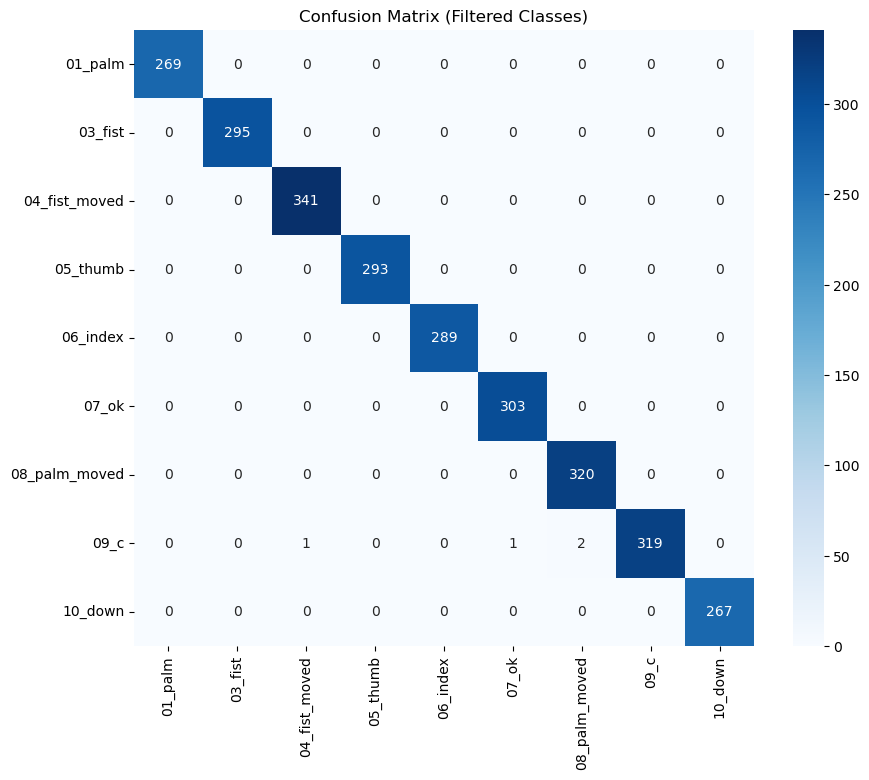

In [34]:
# 1. First check your class distribution
print("Unique classes in y_true:", np.unique(y_true))
print("Model output shape:", y_pred.shape)  # Should be (samples, classes)

# 2. Get the actual class names present
present_classes = np.unique(y_true)
filtered_class_names = [name for name, idx in gesture_classes.items() 
                       if idx in present_classes]

# 3. Generate classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred_classes, 
                          target_names=filtered_class_names))

# 4. Verify against confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=filtered_class_names,
            yticklabels=filtered_class_names)
plt.title('Confusion Matrix (Filtered Classes)')
plt.show()

In [36]:
unique_train, counts_train = np.unique(np.argmax(y_train, axis=1), return_counts=True)
print(dict(zip(unique_train, counts_train)))

{0: 1454, 2: 1388, 3: 1363, 4: 1413, 5: 1431, 6: 1383, 7: 1377, 8: 1366, 9: 1422}


In [38]:
unique_test, counts_test = np.unique(y_true, return_counts=True)
print("Test set class distribution:", dict(zip(unique_test, counts_test)))

Test set class distribution: {0: 269, 2: 295, 3: 341, 4: 293, 5: 289, 6: 303, 7: 320, 8: 323, 9: 267}


In [44]:
model.save('final_gesture_model.keras')

In [46]:
def predict_new_image(image_path):
    img = load_img(image_path, color_mode='grayscale', target_size=(120, 160))
    img_array = img_to_array(img)/255.0
    img_array = np.expand_dims(img_array, axis=0)
    pred = model.predict(img_array)
    return list(gesture_classes.keys())[np.argmax(pred)]

In [48]:
import tensorflow as tf
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

INFO:tensorflow:Assets written to: C:\Users\krith\AppData\Local\Temp\tmpjn9m23ex\assets


INFO:tensorflow:Assets written to: C:\Users\krith\AppData\Local\Temp\tmpjn9m23ex\assets


Saved artifact at 'C:\Users\krith\AppData\Local\Temp\tmpjn9m23ex'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 120, 160, 1), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  2124074518096: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2124074519632: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2124074520784: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2124074520976: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2124074517136: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2124074520208: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2124074518288: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2124074520016: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2124074519824: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2124074522128: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2124

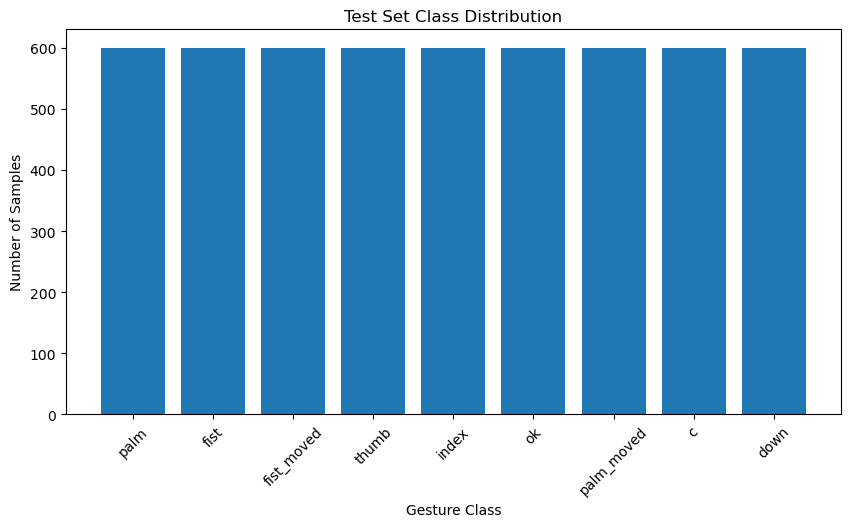

In [79]:
import numpy as np
import matplotlib.pyplot as plt

# 1. Get class distribution (works for both formats)
y_test_classes = y_test if len(y_test.shape) == 1 else np.argmax(y_test, axis=1)
unique_classes, class_counts = np.unique(y_test_classes, return_counts=True)
test_distribution = dict(zip(unique_classes, class_counts))

# 2. Define class names
class_names = {
    0: 'palm',
    1: 'l',
    2: 'fist',
    3: 'fist_moved',
    4: 'thumb',
    5: 'index',
    6: 'ok',
    7: 'palm_moved',
    8: 'c',
    9: 'down'
}

# 3. Filter present classes
present_classes = {k: class_names[k] for k in test_distribution}

# 4. Visualize
plt.figure(figsize=(10,5))
plt.bar(present_classes.values(), test_distribution.values())
plt.title('Test Set Class Distribution')
plt.xlabel('Gesture Class')
plt.ylabel('Number of Samples')
plt.xticks(rotation=45)  # Fixed typo: was plt.sticks()
plt.show()

In [81]:
print("y_test shape:", y_test.shape)
print("First 5 y_test values:", y_test[:5])
print("Test distribution:", test_distribution)

y_test shape: (5400,)
First 5 y_test values: [4 5 7 9 7]
Test distribution: {0: 600, 2: 600, 3: 600, 4: 600, 5: 600, 6: 600, 7: 600, 8: 600, 9: 600}


Sample 5318: Class 0


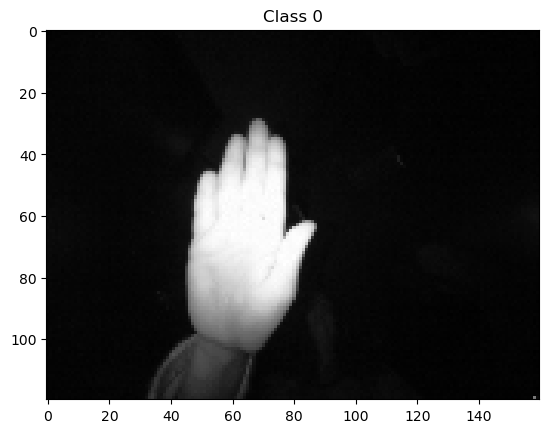

Sample 1117: Class 7


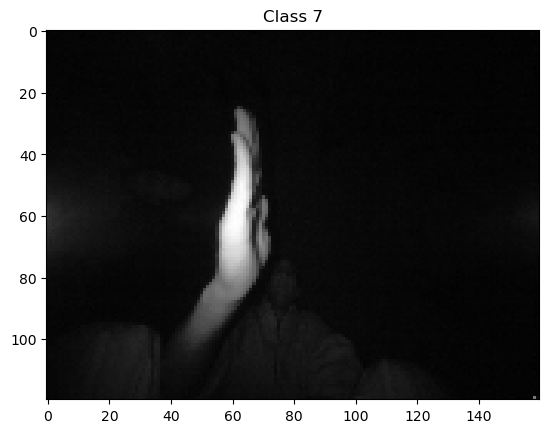

Sample 4858: Class 7


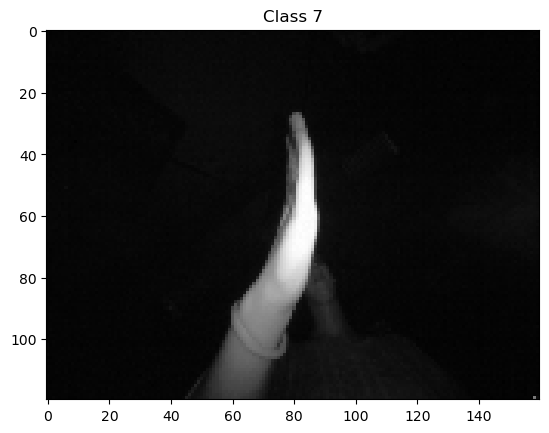

Sample 1420: Class 8


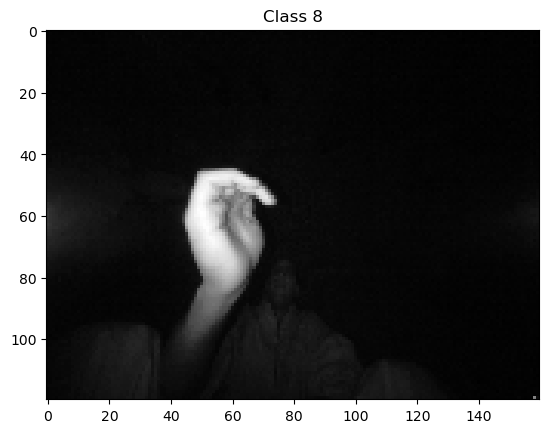

Sample 793: Class 9


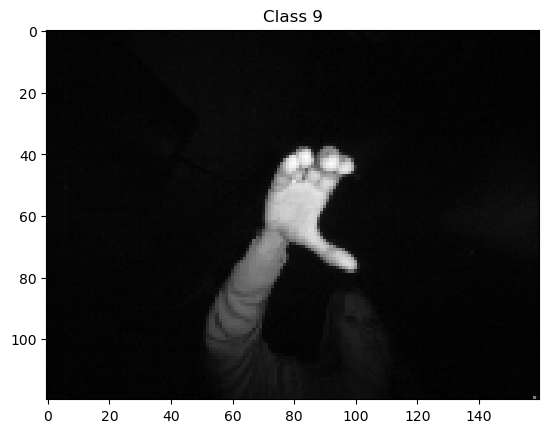

In [87]:
# Verify samples are truly different
import random
sample_idx = random.sample(range(len(X_test)), 5)
for idx in sample_idx:
    print(f"Sample {idx}: Class {y_test[idx]}")
    plt.imshow(X_test[idx].squeeze(), cmap='gray')
    plt.title(f"Class {y_test[idx]}")
    plt.show()

In [89]:
# Use regular splitting without stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=None
)

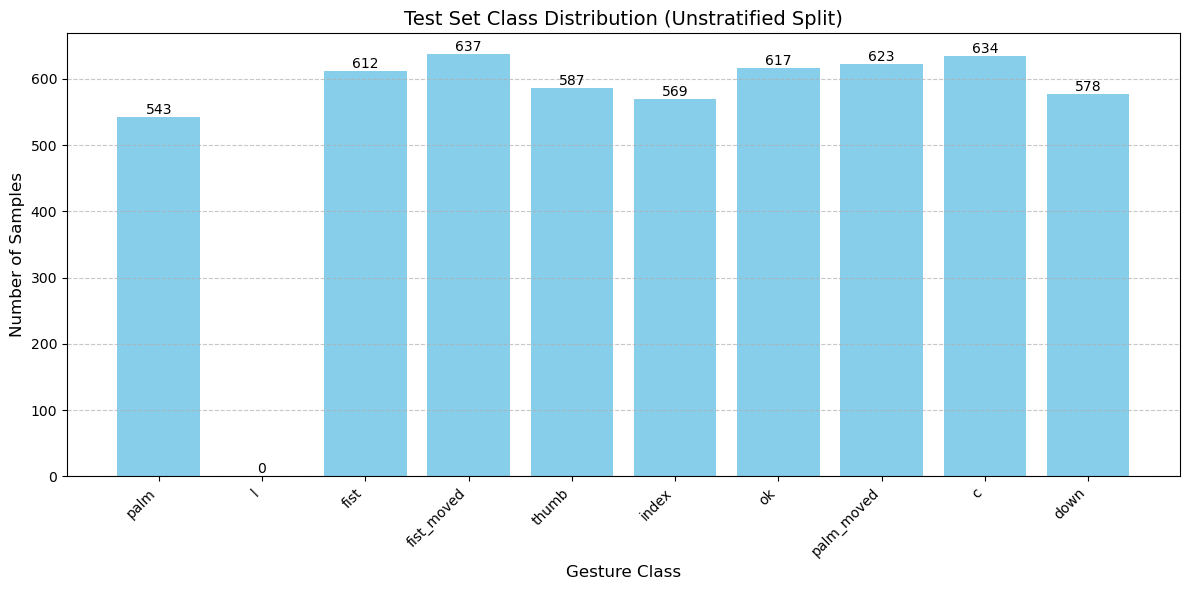


Exact class distribution:
palm (0): 543 samples
fist (2): 612 samples
fist_moved (3): 637 samples
thumb (4): 587 samples
index (5): 569 samples
ok (6): 617 samples
palm_moved (7): 623 samples
c (8): 634 samples
down (9): 578 samples


In [91]:
import numpy as np
import matplotlib.pyplot as plt

# 1. First convert y_test to class indices if it's one-hot encoded
if len(y_test.shape) > 1:  # If one-hot encoded
    y_test_classes = np.argmax(y_test, axis=1)
else:
    y_test_classes = y_test

# 2. Get class distribution
unique_classes, class_counts = np.unique(y_test_classes, return_counts=True)
test_distribution = dict(zip(unique_classes, class_counts))

# 3. Define class names (update with your actual gesture names)
class_names = {
    0: 'palm',
    1: 'l',
    2: 'fist',
    3: 'fist_moved',
    4: 'thumb',
    5: 'index',
    6: 'ok',
    7: 'palm_moved',
    8: 'c',
    9: 'down'
}

# 4. Create the plot
plt.figure(figsize=(12, 6))

# Bar plot
bars = plt.bar(class_names.values(), 
             [test_distribution.get(i, 0) for i in range(10)],
             color='skyblue')

# Add exact counts on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height)}',
            ha='center', va='bottom')

# Customize plot
plt.title('Test Set Class Distribution (Unstratified Split)', fontsize=14)
plt.xlabel('Gesture Class', fontsize=12)
plt.ylabel('Number of Samples', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show plot
plt.tight_layout()
plt.show()

# Print the exact distribution
print("\nExact class distribution:")
for class_idx, count in sorted(test_distribution.items()):
    print(f"{class_names[class_idx]} ({class_idx}): {count} samples")